In [1]:
!python -V

Python 3.12.1


In [42]:
import mlflow
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-exp")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment_tracking/mlruns/1', creation_time=1747000323162, experiment_id='1', last_update_time=1747000323162, lifecycle_stage='active', name='nyc-taxi-exp', tags={}>

In [3]:
pd.__version__

'1.4.2'

In [4]:
# df1 = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')
# df2 = pd.read_parquet('../data/yellow_tripdata_2023-02.parquet')
# df1.head()

In [5]:
df = pd.read_parquet('../data/green_tripdata_2023-01.parquet')
len(df.columns), df.shape

(20, (68211, 20))

In [8]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00


In [9]:
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df['duration'].apply(lambda x: x.total_seconds() / 60)

df = df.loc[((df.duration >= 1) & (df.duration <= 60))]

In [10]:
df.shape

(65946, 21)

In [8]:
3009173 / 3066766

0.9812202822125979

In [11]:
def read_clean_df(filename):
    df = pd.read_parquet(filename)
    
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda x: x.total_seconds() / 60)
    
    df = df.loc[((df.duration >= 1) & (df.duration <= 60))]
    
    cat_feats = ['PULocationID', 'DOLocationID']
    df[cat_feats] = df[cat_feats].astype(str)
    
    return df

In [12]:
df1 = read_clean_df('../data/green_tripdata_2023-01.parquet')
df2 = read_clean_df('../data/green_tripdata_2023-02.parquet')
df3 = read_clean_df('../data/green_tripdata_2023-03.parquet')

In [13]:
len(df1.columns)

21

In [14]:
import sklearn
sklearn.__version__

'1.6.1'

In [15]:
df1.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [16]:
cat_feats = ['PULocationID', 'DOLocationID']
train_dicts = df1[cat_feats].to_dict(orient='records')

In [17]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [18]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 131892 stored elements and shape (65946, 467)>

In [19]:
target = 'duration'
y_train = df1[target].values
y_train

array([11.01666667,  6.76666667,  6.33333333, ..., 16.        ,
       18.        , 16.        ], shape=(65946,))

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_10276/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_10276/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


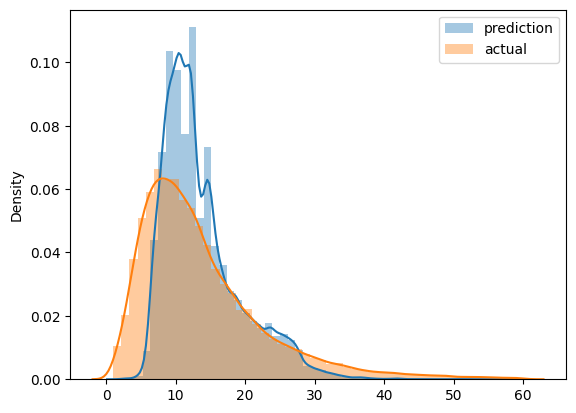

In [22]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [24]:
mean_squared_error(y_train, y_pred)

49.56071980565113

In [25]:
mean_squared_error(y_train, y_pred)**(.5)

7.039937485919256

In [26]:
valid_dicts = df2[cat_feats].to_dict(orient='records')

In [27]:
X_valid = dv.transform(valid_dicts)

In [28]:
y_valid = df2[target].values
y_valid

array([19.58333333, 17.55      , 23.71666667, ..., 17.        ,
       17.        ,  5.        ], shape=(62574,))

In [29]:
X_valid

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 125111 stored elements and shape (62574, 467)>

In [30]:
y_pred_valid = lr.predict(X_valid)

In [31]:
mean_squared_error(y_valid, y_pred_valid)**(.5)

7.356158578732979

/tmp/ipykernel_10276/4278250169.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_valid, label='prediction')
/tmp/ipykernel_10276/4278250169.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_valid, label='actual')


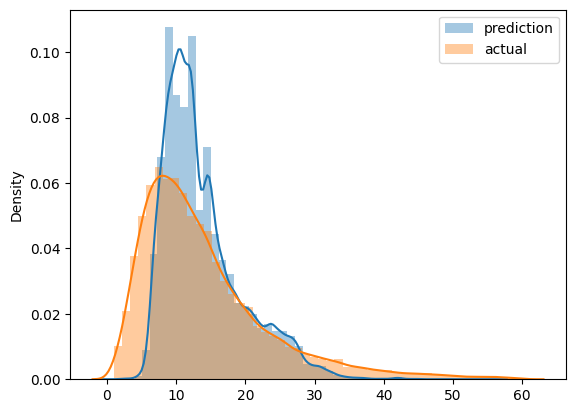

In [32]:
sns.distplot(y_pred_valid, label='prediction')
sns.distplot(y_valid, label='actual')

plt.legend()

In [37]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [44]:
with mlflow.start_run():

    mlflow.set_tag("developer", "mmichal")

    mlflow.log_param("train-data-path", '../data/green_tripdata_2023-01.parquet')
    mlflow.log_param("valid-data-path", '../data/green_tripdata_2023-02.parquet')
    
    alpha = 0.01

    mlflow.log_param("alpha", alpha)

    lasso_reg = Lasso(alpha)
    lasso_reg.fit(X_train, y_train)

    y_pred = lasso_reg.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred)**(0.5)
    mlflow.log_metric("rmse", rmse)

In [45]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_valid, label=y_valid)

In [49]:
def objective(params):
    with mlflow.start_run():

        mlflow.set_tag("developer", "mmichal")
        mlflow.set_tag("model", "xgboost")
    
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds = 50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_valid, y_pred)**(0.5)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}



In [50]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3), exp(0) -> [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed':42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:8.64306                                                    
[1]	validation-rmse:8.17278                                                    
[2]	validation-rmse:7.84799                                                    
  0%|                                   | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:39:21] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:7.53851                                                    
[4]	validation-rmse:7.35060                                                    
[5]	validation-rmse:7.15683                                                    
[6]	validation-rmse:7.04684                                                    
[7]	validation-rmse:6.96579                                                    
[8]	validation-rmse:6.89695                                                    
[9]	validation-rmse:6.78683                                                    
[10]	validation-rmse:6.73834                                                   
[11]	validation-rmse:6.69210                                                   
[12]	validation-rmse:6.65923                                                   
[13]	validation-rmse:6.63194                                                   
[14]	validation-rmse:6.60475                                                   
[15]	validation-rmse:6.56846            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:40:11] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:6.47627                                                    
[3]	validation-rmse:6.25710                                                    
[4]	validation-rmse:6.12845                                                    
[5]	validation-rmse:6.08058                                                    
[6]	validation-rmse:6.03674                                                    
[7]	validation-rmse:6.01241                                                    
[8]	validation-rmse:5.98201                                                    
[9]	validation-rmse:5.97806                                                    
[10]	validation-rmse:5.95984                                                   
[11]	validation-rmse:5.95678                                                   
[12]	validation-rmse:5.94935                                                   
[13]	validation-rmse:5.94348                                                   
[14]	validation-rmse:5.93556            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:40:38] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[12]	validation-rmse:8.65654                                                   
[13]	validation-rmse:8.62410                                                   
[14]	validation-rmse:8.60133                                                   
[15]	validation-rmse:8.57810                                                   
[16]	validation-rmse:8.55143                                                   
[17]	validation-rmse:8.53389                                                   
[18]	validation-rmse:8.51458                                                   
[19]	validation-rmse:8.49333                                                   
[20]	validation-rmse:8.46711                                                   
[21]	validation-rmse:8.44242                                                   
[22]	validation-rmse:8.42816                                                   
[23]	validation-rmse:8.41204                                                   
[24]	validation-rmse:8.39318            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:40:56] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[9]	validation-rmse:8.35874                                                    
[10]	validation-rmse:8.29667                                                   
[11]	validation-rmse:8.25204                                                   
[12]	validation-rmse:8.21187                                                   
[13]	validation-rmse:8.16531                                                   
[14]	validation-rmse:8.12891                                                   
[15]	validation-rmse:8.09553                                                   
[16]	validation-rmse:8.04882                                                   
[17]	validation-rmse:8.01940                                                   
[18]	validation-rmse:7.98223                                                   
[19]	validation-rmse:7.95491                                                   
[20]	validation-rmse:7.93286                                                   
[21]	validation-rmse:7.90895            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:41:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:6.32047                                                    
[2]	validation-rmse:6.23351                                                    
[3]	validation-rmse:6.21164                                                    
[4]	validation-rmse:6.20852                                                    
[5]	validation-rmse:6.21041                                                    
[6]	validation-rmse:6.21245                                                    
[7]	validation-rmse:6.21387                                                    
[8]	validation-rmse:6.21505                                                    
[9]	validation-rmse:6.21516                                                    
[10]	validation-rmse:6.21500                                                   
[11]	validation-rmse:6.21500                                                   
[12]	validation-rmse:6.21501                                                   
[13]	validation-rmse:6.21518            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:41:28] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:6.65490                                                    
[5]	validation-rmse:6.58730                                                    
[6]	validation-rmse:6.51041                                                    
[7]	validation-rmse:6.47374                                                    
[8]	validation-rmse:6.43775                                                    
[9]	validation-rmse:6.40987                                                    
[10]	validation-rmse:6.38074                                                   
[11]	validation-rmse:6.32775                                                   
[12]	validation-rmse:6.32357                                                   
[13]	validation-rmse:6.31310                                                   
[14]	validation-rmse:6.30379                                                   
[15]	validation-rmse:6.26198                                                   
[16]	validation-rmse:6.25037            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:41:32] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:8.15687                                                    
[5]	validation-rmse:7.99676                                                    
[6]	validation-rmse:7.84727                                                    
[7]	validation-rmse:7.72689                                                    
[8]	validation-rmse:7.60419                                                    
[9]	validation-rmse:7.51040                                                    
[10]	validation-rmse:7.42065                                                   
[11]	validation-rmse:7.34441                                                   
[12]	validation-rmse:7.27793                                                   
[13]	validation-rmse:7.19663                                                   
[14]	validation-rmse:7.13758                                                   
[15]	validation-rmse:7.07567                                                   
[16]	validation-rmse:7.03357            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:42:22] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:6.66518                                                    
[5]	validation-rmse:6.58327                                                    
[6]	validation-rmse:6.50443                                                    
[7]	validation-rmse:6.46138                                                    
[8]	validation-rmse:6.35622                                                    
[9]	validation-rmse:6.33230                                                    
[10]	validation-rmse:6.30885                                                   
[11]	validation-rmse:6.28245                                                   
[12]	validation-rmse:6.26864                                                   
[13]	validation-rmse:6.23814                                                   
[14]	validation-rmse:6.22661                                                   
[15]	validation-rmse:6.21829                                                   
[16]	validation-rmse:6.17722            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:43:03] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:6.36259                                                    
[2]	validation-rmse:6.26103                                                    
[3]	validation-rmse:6.20896                                                    
[4]	validation-rmse:6.16176                                                    
[5]	validation-rmse:6.15388                                                    
[6]	validation-rmse:6.15981                                                    
[7]	validation-rmse:6.15155                                                    
[8]	validation-rmse:6.14477                                                    
[9]	validation-rmse:6.14965                                                    
[10]	validation-rmse:6.15205                                                   
[11]	validation-rmse:6.15485                                                   
[12]	validation-rmse:6.15559                                                   
[13]	validation-rmse:6.15637            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:43:09] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.61163                                                    
[2]	validation-rmse:8.32713                                                    
[3]	validation-rmse:8.08224                                                    
[4]	validation-rmse:7.86167                                                    
[5]	validation-rmse:7.65728                                                    
[6]	validation-rmse:7.48421                                                    
[7]	validation-rmse:7.34591                                                    
[8]	validation-rmse:7.21042                                                    
[9]	validation-rmse:7.10697                                                    
[10]	validation-rmse:7.01853                                                   
[11]	validation-rmse:6.93841                                                   
[12]	validation-rmse:6.85421                                                   
[13]	validation-rmse:6.79218            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:43:28] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:6.44052                                                    
[3]	validation-rmse:6.26685                                                    
[4]	validation-rmse:6.20157                                                    
[5]	validation-rmse:6.16012                                                    
[6]	validation-rmse:6.11977                                                    
[7]	validation-rmse:6.09076                                                    
[8]	validation-rmse:6.06820                                                    
[9]	validation-rmse:6.05483                                                    
[10]	validation-rmse:6.04235                                                   
[11]	validation-rmse:6.04426                                                   
[12]	validation-rmse:6.03366                                                   
[13]	validation-rmse:6.03080                                                   
[14]	validation-rmse:6.02623            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:44:02] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[8]	validation-rmse:8.17215                                                    
[9]	validation-rmse:8.11769                                                    
[10]	validation-rmse:8.04755                                                   
[11]	validation-rmse:7.99866                                                   
[12]	validation-rmse:7.95280                                                   
[13]	validation-rmse:7.90689                                                   
[14]	validation-rmse:7.87218                                                   
[15]	validation-rmse:7.82540                                                   
[16]	validation-rmse:7.79505                                                   
[17]	validation-rmse:7.76630                                                   
[18]	validation-rmse:7.73715                                                   
[19]	validation-rmse:7.69190                                                   
[20]	validation-rmse:7.66581            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:44:29] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:7.05850                                                    
[6]	validation-rmse:6.97247                                                    
[7]	validation-rmse:6.87197                                                    
[8]	validation-rmse:6.82098                                                    
[9]	validation-rmse:6.77614                                                    
[10]	validation-rmse:6.73300                                                   
[11]	validation-rmse:6.70023                                                   
[12]	validation-rmse:6.66052                                                   
[13]	validation-rmse:6.63878                                                   
[14]	validation-rmse:6.61094                                                   
[15]	validation-rmse:6.59009                                                   
[16]	validation-rmse:6.57009                                                   
[17]	validation-rmse:6.55299            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:45:13] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:8.41383                                                    
[7]	validation-rmse:8.30983                                                    
[8]	validation-rmse:8.23201                                                    
[9]	validation-rmse:8.14010                                                    
[10]	validation-rmse:8.07406                                                   
[11]	validation-rmse:7.99508                                                   
[12]	validation-rmse:7.93941                                                   
[13]	validation-rmse:7.86857                                                   
[14]	validation-rmse:7.82128                                                   
[15]	validation-rmse:7.76311                                                   
[16]	validation-rmse:7.72379                                                   
[17]	validation-rmse:7.67274                                                   
[18]	validation-rmse:7.63630            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:45:46] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:6.81233                                                    
[6]	validation-rmse:6.74526                                                    
[7]	validation-rmse:6.68799                                                    
[8]	validation-rmse:6.60269                                                    
[9]	validation-rmse:6.57301                                                    
[10]	validation-rmse:6.54801                                                   
[11]	validation-rmse:6.51757                                                   
[12]	validation-rmse:6.49453                                                   
[13]	validation-rmse:6.48087                                                   
[14]	validation-rmse:6.44774                                                   
[15]	validation-rmse:6.43902                                                   
[16]	validation-rmse:6.42697                                                   
[17]	validation-rmse:6.41928            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:46:37] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:6.89834                                                    
[3]	validation-rmse:6.65558                                                    
[4]	validation-rmse:6.44606                                                    
[5]	validation-rmse:6.37454                                                    
[6]	validation-rmse:6.29611                                                    
[7]	validation-rmse:6.24447                                                    
[8]	validation-rmse:6.21632                                                    
[9]	validation-rmse:6.19741                                                    
[10]	validation-rmse:6.17438                                                   
[11]	validation-rmse:6.14459                                                   
[12]	validation-rmse:6.11910                                                   
[13]	validation-rmse:6.10223                                                   
[14]	validation-rmse:6.08919            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:47:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:7.17016                                                    
[4]	validation-rmse:6.90961                                                    
[5]	validation-rmse:6.77189                                                    
[6]	validation-rmse:6.60360                                                    
[7]	validation-rmse:6.53477                                                    
[8]	validation-rmse:6.48577                                                    
[9]	validation-rmse:6.40136                                                    
[10]	validation-rmse:6.36917                                                   
[11]	validation-rmse:6.34075                                                   
[12]	validation-rmse:6.30206                                                   
[13]	validation-rmse:6.26437                                                   
[14]	validation-rmse:6.23463                                                   
[15]	validation-rmse:6.21723            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:48:25] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:7.54613                                                    
[5]	validation-rmse:7.35427                                                    
[6]	validation-rmse:7.25943                                                    
[7]	validation-rmse:7.12627                                                    
[8]	validation-rmse:7.06348                                                    
[9]	validation-rmse:7.02079                                                    
[10]	validation-rmse:6.97483                                                   
[11]	validation-rmse:6.94404                                                   
[12]	validation-rmse:6.87215                                                   
[13]	validation-rmse:6.83689                                                   
[14]	validation-rmse:6.81534                                                   
[15]	validation-rmse:6.79445                                                   
[16]	validation-rmse:6.77351            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:49:04] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:7.26939                                                    
[4]	validation-rmse:7.13125                                                    
[5]	validation-rmse:7.02524                                                    
[6]	validation-rmse:6.95226                                                    
[7]	validation-rmse:6.82384                                                    
[8]	validation-rmse:6.77807                                                    
[9]	validation-rmse:6.71262                                                    
[10]	validation-rmse:6.66022                                                   
[11]	validation-rmse:6.60323                                                   
[12]	validation-rmse:6.56859                                                   
[13]	validation-rmse:6.54317                                                   
[14]	validation-rmse:6.46492                                                   
[15]	validation-rmse:6.44293            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:49:35] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:6.77126                                                    
[6]	validation-rmse:6.71492                                                    
[7]	validation-rmse:6.65457                                                    
[8]	validation-rmse:6.62775                                                    
[9]	validation-rmse:6.60334                                                    
[10]	validation-rmse:6.58484                                                   
[11]	validation-rmse:6.53221                                                   
[12]	validation-rmse:6.51926                                                   
[13]	validation-rmse:6.49468                                                   
[14]	validation-rmse:6.48160                                                   
[15]	validation-rmse:6.46201                                                   
[16]	validation-rmse:6.45182                                                   
[17]	validation-rmse:6.44567            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:50:14] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.70022                                                    
[4]	validation-rmse:6.52724                                                    
[5]	validation-rmse:6.42504                                                    
[6]	validation-rmse:6.36712                                                    
[7]	validation-rmse:6.33721                                                    
[8]	validation-rmse:6.30436                                                    
[9]	validation-rmse:6.27780                                                    
[10]	validation-rmse:6.25795                                                   
[11]	validation-rmse:6.21862                                                   
[12]	validation-rmse:6.20653                                                   
[13]	validation-rmse:6.18627                                                   
[14]	validation-rmse:6.17236                                                   
[15]	validation-rmse:6.16746            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:51:07] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:6.53507                                                    
[5]	validation-rmse:6.42842                                                    
[6]	validation-rmse:6.36362                                                    
[7]	validation-rmse:6.28974                                                    
[8]	validation-rmse:6.26147                                                    
[9]	validation-rmse:6.23357                                                    
[10]	validation-rmse:6.21744                                                   
[11]	validation-rmse:6.20652                                                   
[12]	validation-rmse:6.19226                                                   
[13]	validation-rmse:6.17852                                                   
[14]	validation-rmse:6.17135                                                   
[15]	validation-rmse:6.16103                                                   
[16]	validation-rmse:6.15149            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:51:59] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.18919                                                    
[2]	validation-rmse:7.79704                                                    
[3]	validation-rmse:7.47112                                                    
[4]	validation-rmse:7.18980                                                    
[5]	validation-rmse:6.96561                                                    
[6]	validation-rmse:6.80524                                                    
[7]	validation-rmse:6.66828                                                    
[8]	validation-rmse:6.55629                                                    
[9]	validation-rmse:6.47693                                                    
[10]	validation-rmse:6.39614                                                   
[11]	validation-rmse:6.33798                                                   
[12]	validation-rmse:6.28997                                                   
[13]	validation-rmse:6.25303            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:53:20] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[5]	validation-rmse:6.28719                                                    
[6]	validation-rmse:6.23933                                                    
[7]	validation-rmse:6.21990                                                    
[8]	validation-rmse:6.19511                                                    
[9]	validation-rmse:6.18567                                                    
[10]	validation-rmse:6.16456                                                   
[11]	validation-rmse:6.15029                                                   
[12]	validation-rmse:6.14998                                                   
[13]	validation-rmse:6.13833                                                   
[14]	validation-rmse:6.13561                                                   
[15]	validation-rmse:6.13046                                                   
[16]	validation-rmse:6.12788                                                   
[17]	validation-rmse:6.12507            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:53:40] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:7.54594                                                    
[4]	validation-rmse:7.29160                                                    
[5]	validation-rmse:7.11220                                                    
[6]	validation-rmse:6.96789                                                    
[7]	validation-rmse:6.82670                                                    
[8]	validation-rmse:6.73935                                                    
[9]	validation-rmse:6.64336                                                    
[10]	validation-rmse:6.58695                                                   
[11]	validation-rmse:6.50933                                                   
[12]	validation-rmse:6.45066                                                   
[13]	validation-rmse:6.41960                                                   
[14]	validation-rmse:6.38147                                                   
[15]	validation-rmse:6.34881            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:54:43] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:6.48902                                                    
[5]	validation-rmse:6.42531                                                    
[6]	validation-rmse:6.35779                                                    
[7]	validation-rmse:6.32390                                                    
[8]	validation-rmse:6.30750                                                    
[9]	validation-rmse:6.29544                                                    
[10]	validation-rmse:6.28259                                                   
[11]	validation-rmse:6.21967                                                   
[12]	validation-rmse:6.20797                                                   
[13]	validation-rmse:6.20117                                                   
[14]	validation-rmse:6.19601                                                   
[15]	validation-rmse:6.18881                                                   
[16]	validation-rmse:6.17835            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:55:12] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:6.00646                                                    
[3]	validation-rmse:5.96511                                                    
[4]	validation-rmse:5.96018                                                    
[5]	validation-rmse:5.96259                                                    
[6]	validation-rmse:5.95119                                                    
[7]	validation-rmse:5.95155                                                    
[8]	validation-rmse:5.94783                                                    
[9]	validation-rmse:5.93945                                                    
[10]	validation-rmse:5.94925                                                   
[11]	validation-rmse:5.94730                                                   
[12]	validation-rmse:5.95409                                                   
[13]	validation-rmse:5.94663                                                   
[14]	validation-rmse:5.95044            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:55:25] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.65441                                                    
[4]	validation-rmse:6.49717                                                    
[5]	validation-rmse:6.36163                                                    
[6]	validation-rmse:6.28654                                                    
[7]	validation-rmse:6.22286                                                    
[8]	validation-rmse:6.19254                                                    
[9]	validation-rmse:6.16531                                                    
[10]	validation-rmse:6.14277                                                   
[11]	validation-rmse:6.12364                                                   
[12]	validation-rmse:6.11617                                                   
[13]	validation-rmse:6.10374                                                   
[14]	validation-rmse:6.09593                                                   
[15]	validation-rmse:6.09340            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:56:09] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:7.80183                                                    
[7]	validation-rmse:7.72195                                                    
[8]	validation-rmse:7.65452                                                    
[9]	validation-rmse:7.55154                                                    
[10]	validation-rmse:7.49196                                                   
[11]	validation-rmse:7.44700                                                   
[12]	validation-rmse:7.39596                                                   
[13]	validation-rmse:7.35721                                                   
[14]	validation-rmse:7.29435                                                   
[15]	validation-rmse:7.26170                                                   
[16]	validation-rmse:7.23117                                                   
[17]	validation-rmse:7.20482                                                   
[18]	validation-rmse:7.15356            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:56:42] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.24097                                                    
[4]	validation-rmse:6.15134                                                    
[5]	validation-rmse:6.11811                                                    
[6]	validation-rmse:6.09719                                                    
[7]	validation-rmse:6.08822                                                    
[8]	validation-rmse:6.07841                                                    
[9]	validation-rmse:6.06937                                                    
[10]	validation-rmse:6.06379                                                   
[11]	validation-rmse:6.06150                                                   
[12]	validation-rmse:6.05590                                                   
[13]	validation-rmse:6.04989                                                   
[14]	validation-rmse:6.04044                                                   
[15]	validation-rmse:6.03256            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:57:11] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:7.34227                                                    
[3]	validation-rmse:7.00972                                                    
[4]	validation-rmse:6.74379                                                    
[5]	validation-rmse:6.56811                                                    
[6]	validation-rmse:6.44005                                                    
[7]	validation-rmse:6.33181                                                    
[8]	validation-rmse:6.26438                                                    
[9]	validation-rmse:6.19406                                                    
[10]	validation-rmse:6.15154                                                   
[11]	validation-rmse:6.11548                                                   
[12]	validation-rmse:6.08554                                                   
[13]	validation-rmse:6.06352                                                   
[14]	validation-rmse:6.03852            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:57:43] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[11]	validation-rmse:8.03690
[12]	validation-rmse:7.99510                                                   
[13]	validation-rmse:7.96227                                                   
[14]	validation-rmse:7.92914                                                   
[15]	validation-rmse:7.89469                                                   
[16]	validation-rmse:7.86367                                                   
[17]	validation-rmse:7.81885                                                   
[18]	validation-rmse:7.78680                                                   
[19]	validation-rmse:7.74475                                                   
[20]	validation-rmse:7.70085                                                   
[21]	validation-rmse:7.67779                                                   
[22]	validation-rmse:7.66043                                                   
[23]	validation-rmse:7.63353                                                   
[24]	valida

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:57:56] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:7.68481                                                    
[5]	validation-rmse:7.48895                                                    
[6]	validation-rmse:7.35260                                                    
[7]	validation-rmse:7.21175                                                    
[8]	validation-rmse:7.11776                                                    
[9]	validation-rmse:7.02460                                                    
[10]	validation-rmse:6.92902                                                   
[11]	validation-rmse:6.87235                                                   
[12]	validation-rmse:6.82203                                                   
[13]	validation-rmse:6.75774                                                   
[14]	validation-rmse:6.72149                                                   
[15]	validation-rmse:6.68844                                                   
[16]	validation-rmse:6.66072            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:58:48] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:7.18192                                                    
[5]	validation-rmse:7.03147                                                    
[6]	validation-rmse:6.87167                                                    
[7]	validation-rmse:6.78308                                                    
[8]	validation-rmse:6.68623                                                    
[9]	validation-rmse:6.62785                                                    
[10]	validation-rmse:6.58665                                                   
[11]	validation-rmse:6.54514                                                   
[12]	validation-rmse:6.51096                                                   
[13]	validation-rmse:6.46603                                                   
[14]	validation-rmse:6.44774                                                   
[15]	validation-rmse:6.42839                                                   
[16]	validation-rmse:6.40118            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:59:39] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.37949                                                    
[4]	validation-rmse:6.35654                                                    
[5]	validation-rmse:6.34478                                                    
[6]	validation-rmse:6.31323                                                    
[7]	validation-rmse:6.29390                                                    
[8]	validation-rmse:6.27596                                                    
[9]	validation-rmse:6.26927                                                    
[10]	validation-rmse:6.26138                                                   
[11]	validation-rmse:6.24600                                                   
[12]	validation-rmse:6.23311                                                   
[13]	validation-rmse:6.22077                                                   
[14]	validation-rmse:6.21265                                                   
[15]	validation-rmse:6.20248            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:00:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.22505                                                    
[4]	validation-rmse:6.19032                                                    
[5]	validation-rmse:6.14649                                                    
[6]	validation-rmse:6.11828                                                    
[7]	validation-rmse:6.10971                                                    
[8]	validation-rmse:6.08321                                                    
[9]	validation-rmse:6.06717                                                    
[10]	validation-rmse:6.06012                                                   
[11]	validation-rmse:6.03723                                                   
[12]	validation-rmse:6.01978                                                   
[13]	validation-rmse:6.01409                                                   
[14]	validation-rmse:6.00922                                                   
[15]	validation-rmse:6.00589            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:00:27] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.55250                                                    
[2]	validation-rmse:7.09798                                                    
[3]	validation-rmse:6.78560                                                    
[4]	validation-rmse:6.60018                                                    
[5]	validation-rmse:6.46876                                                    
[6]	validation-rmse:6.37208                                                    
[7]	validation-rmse:6.31793                                                    
[8]	validation-rmse:6.28332                                                    
[9]	validation-rmse:6.24779                                                    
[10]	validation-rmse:6.22144                                                   
[11]	validation-rmse:6.20403                                                   
[12]	validation-rmse:6.19713                                                   
[13]	validation-rmse:6.17642            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:00:38] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.41837                                                    
[4]	validation-rmse:6.35193                                                    
[5]	validation-rmse:6.31030                                                    
[6]	validation-rmse:6.27896                                                    
[7]	validation-rmse:6.25541                                                    
[8]	validation-rmse:6.24104                                                    
[9]	validation-rmse:6.23613                                                    
[10]	validation-rmse:6.21201                                                   
[11]	validation-rmse:6.20209                                                   
[12]	validation-rmse:6.19133                                                   
[13]	validation-rmse:6.18896                                                   
[14]	validation-rmse:6.17961                                                   
[15]	validation-rmse:6.16904            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:01:11] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[7]	validation-rmse:7.66511                                                    
[8]	validation-rmse:7.59561                                                    
[9]	validation-rmse:7.53298                                                    
[10]	validation-rmse:7.48659                                                   
[11]	validation-rmse:7.43389                                                   
[12]	validation-rmse:7.38105                                                   
[13]	validation-rmse:7.34613                                                   
[14]	validation-rmse:7.31756                                                   
[15]	validation-rmse:7.27394                                                   
[16]	validation-rmse:7.21756                                                   
[17]	validation-rmse:7.17632                                                   
[18]	validation-rmse:7.14948                                                   
[19]	validation-rmse:7.12675            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:01:34] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:8.13297                                                    
[7]	validation-rmse:8.04988                                                    
[8]	validation-rmse:7.96920                                                    
[9]	validation-rmse:7.90710                                                    
[10]	validation-rmse:7.84825                                                   
[11]	validation-rmse:7.76730                                                   
[12]	validation-rmse:7.72235                                                   
[13]	validation-rmse:7.67830                                                   
[14]	validation-rmse:7.64047                                                   
[15]	validation-rmse:7.60382                                                   
[16]	validation-rmse:7.54541                                                   
[17]	validation-rmse:7.51475                                                   
[18]	validation-rmse:7.48529            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:02:05] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.57138                                                    
[3]	validation-rmse:8.36972                                                    
[4]	validation-rmse:8.17976                                                    
[5]	validation-rmse:8.01492                                                    
[6]	validation-rmse:7.85199                                                    
[7]	validation-rmse:7.70964                                                    
[8]	validation-rmse:7.58872                                                    
[9]	validation-rmse:7.46571                                                    
[10]	validation-rmse:7.36634                                                   
[11]	validation-rmse:7.26398                                                   
[12]	validation-rmse:7.18386                                                   
[13]	validation-rmse:7.10260                                                   
[14]	validation-rmse:7.03551            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:02:31] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:6.33281                                                    
[5]	validation-rmse:6.26265                                                    
[6]	validation-rmse:6.18688                                                    
[7]	validation-rmse:6.14626                                                    
[8]	validation-rmse:6.12295                                                    
[9]	validation-rmse:6.10147                                                    
[10]	validation-rmse:6.08076                                                   
[11]	validation-rmse:6.07709                                                   
[12]	validation-rmse:6.05021                                                   
[13]	validation-rmse:6.04694                                                   
[14]	validation-rmse:6.04286                                                   
[15]	validation-rmse:6.01847                                                   
[16]	validation-rmse:6.01410            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:02:44] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.29562                                                    
[4]	validation-rmse:6.19687                                                    
[5]	validation-rmse:6.15556                                                    
[6]	validation-rmse:6.10197                                                    
[7]	validation-rmse:6.07794                                                    
[8]	validation-rmse:6.06657                                                    
[9]	validation-rmse:6.05317                                                    
[10]	validation-rmse:6.03629                                                   
[11]	validation-rmse:6.03143                                                   
[12]	validation-rmse:6.02804                                                   
[13]	validation-rmse:6.02337                                                   
[14]	validation-rmse:6.02062                                                   
[15]	validation-rmse:6.01296            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:03:19] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.09128                                                    
[4]	validation-rmse:6.04815                                                    
[5]	validation-rmse:6.02717                                                    
[6]	validation-rmse:6.02490                                                    
[7]	validation-rmse:6.02378                                                    
[8]	validation-rmse:6.01070                                                    
[9]	validation-rmse:6.01066                                                    
[10]	validation-rmse:6.01035                                                   
[11]	validation-rmse:6.01273                                                   
[12]	validation-rmse:6.00947                                                   
[13]	validation-rmse:6.01100                                                   
[14]	validation-rmse:6.00754                                                   
[15]	validation-rmse:5.99334            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:03:28] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:6.74547                                                    
[4]	validation-rmse:6.55166                                                    
[5]	validation-rmse:6.42173                                                    
[6]	validation-rmse:6.32442                                                    
[7]	validation-rmse:6.27226                                                    
[8]	validation-rmse:6.23422                                                    
[9]	validation-rmse:6.20495                                                    
[10]	validation-rmse:6.17350                                                   
[11]	validation-rmse:6.15586                                                   
[12]	validation-rmse:6.14540                                                   
[13]	validation-rmse:6.13651                                                   
[14]	validation-rmse:6.12940                                                   
[15]	validation-rmse:6.12038            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:04:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:7.30304                                                    
[7]	validation-rmse:7.23155                                                    
[8]	validation-rmse:7.16633                                                    
[9]	validation-rmse:7.12164                                                    
[10]	validation-rmse:7.07988                                                   
[11]	validation-rmse:7.04370                                                   
[12]	validation-rmse:6.99149                                                   
[13]	validation-rmse:6.96457                                                   
[14]	validation-rmse:6.86205                                                   
[15]	validation-rmse:6.83940                                                   
[16]	validation-rmse:6.81720                                                   
[17]	validation-rmse:6.79949                                                   
[18]	validation-rmse:6.77273            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:04:59] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:7.34006
[5]	validation-rmse:7.19847                                                    
[6]	validation-rmse:7.02119                                                    
[7]	validation-rmse:6.88880                                                    
[8]	validation-rmse:6.81893                                                    
[9]	validation-rmse:6.73133                                                    
[10]	validation-rmse:6.68523                                                   
[11]	validation-rmse:6.65191                                                   
[12]	validation-rmse:6.61664                                                   
[13]	validation-rmse:6.58792                                                   
[14]	validation-rmse:6.56950                                                   
[15]	validation-rmse:6.54387                                                   
[16]	validation-rmse:6.52824                                                   
[17]	validat

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:05:46] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.07127                                                    
[3]	validation-rmse:7.76535                                                    
[4]	validation-rmse:7.51981                                                    
[5]	validation-rmse:7.29891                                                    
[6]	validation-rmse:7.12230                                                    
[7]	validation-rmse:6.98865                                                    
[8]	validation-rmse:6.88041                                                    
[9]	validation-rmse:6.76622                                                    
[10]	validation-rmse:6.68015                                                   
[11]	validation-rmse:6.59517                                                   
[12]	validation-rmse:6.53693                                                   
[13]	validation-rmse:6.47656                                                   
[14]	validation-rmse:6.43461            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:06:53] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:7.60939                                                    
[5]	validation-rmse:7.40841                                                    
[6]	validation-rmse:7.25684                                                    
[7]	validation-rmse:7.11254                                                    
[8]	validation-rmse:6.99796                                                    
[9]	validation-rmse:6.90626                                                    
[10]	validation-rmse:6.81940                                                   
[11]	validation-rmse:6.74972                                                   
[12]	validation-rmse:6.69017                                                   
[13]	validation-rmse:6.64871                                                   
[14]	validation-rmse:6.60850                                                   
[15]	validation-rmse:6.56856                                                   
[16]	validation-rmse:6.54428            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:07:58] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:8.05994                                                    
[4]	validation-rmse:7.82334                                                    
[5]	validation-rmse:7.63259                                                    
[6]	validation-rmse:7.45253                                                    
[7]	validation-rmse:7.29970                                                    
[8]	validation-rmse:7.17336                                                    
[9]	validation-rmse:7.05034                                                    
[10]	validation-rmse:6.95812                                                   
[11]	validation-rmse:6.86551                                                   
[12]	validation-rmse:6.79031                                                   
[13]	validation-rmse:6.71124                                                   
[14]	validation-rmse:6.65513                                                   
[15]	validation-rmse:6.59535            

In [51]:
params = {
    'learning_rate':0.10714704100101531,
    'max_depth':73,
    'min_child_weight':4.263622976314913,
    'objective':'reg:linear',
    'reg_alpha':0.028340307229425172,
    'reg_lambda':0.05182432790580689,
    'seed':42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds = 50
)


2025/05/11 23:12:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'df3330d6e69048ceaf75984bbc157574', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:8.82635
[1]	validation-rmse:8.41216
[2]	validation-rmse:8.07127


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [23:12:31] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[3]	validation-rmse:7.76535
[4]	validation-rmse:7.51981
[5]	validation-rmse:7.29891
[6]	validation-rmse:7.12230
[7]	validation-rmse:6.98865
[8]	validation-rmse:6.88041
[9]	validation-rmse:6.76622
[10]	validation-rmse:6.68015
[11]	validation-rmse:6.59517
[12]	validation-rmse:6.53693
[13]	validation-rmse:6.47656
[14]	validation-rmse:6.43461
[15]	validation-rmse:6.39655
[16]	validation-rmse:6.36819
[17]	validation-rmse:6.33662
[18]	validation-rmse:6.31630
[19]	validation-rmse:6.29193
[20]	validation-rmse:6.27665
[21]	validation-rmse:6.26143
[22]	validation-rmse:6.24485
[23]	validation-rmse:6.23112
[24]	validation-rmse:6.22046
[25]	validation-rmse:6.21038
[26]	validation-rmse:6.19802
[27]	validation-rmse:6.18716
[28]	validation-rmse:6.17984
[29]	validation-rmse:6.17299
[30]	validation-rmse:6.16862
[31]	validation-rmse:6.15306
[32]	validation-rmse:6.14364
[33]	validation-rmse:6.13796
[34]	validation-rmse:6.13429
[35]	validation-rmse:6.12909
[36]	validation-rmse:6.12456
[37]	validation-rmse:

2025/05/11 23:13:29 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/11 23:13:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/python/3.12.1/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [23:13:29] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/11 23:13:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
